# Capstone Project

## Overview
This notebook runs the Day 15 capstone simulator: an e-commerce description optimizer
using a contextual bandit (LinUCB, Thompson Sampling, and epsilon-greedy) trained on
an LLM-judge proxy reward with delayed conversion feedback. We evaluate actual
conversion/profit, apply a safety threshold on unsafe content, and estimate policy
value offline using Doubly Robust OPE.


*Objective:** Synthesize everything you’ve learned by designing and implementing a mini version of Sqwish’s optimization engine. This capstone project will have you create a simulated environment and then build an agent that optimizes in that environment, incorporating bandits, proxy rewards, and OPE. It’s a chance to put it all together: bandit algorithms, reward modeling, safety checks, and evaluation in one end-to-end prototype.

**Project Brief:** *E-commerce Description Optimizer.* You will simulate an e-commerce website where an LLM generates product descriptions for users, and the goal is to maximize conversion (purchase) while respecting cost. Three different LLMs (of varying cost and quality) are available. Users have different preferences. You’ll build a contextual bandit agent to route and prompt the LLMs optimally.

**Environment Setup:**

- **User Context:** Define a user persona feature (e.g. budget_sensitive vs quality_seeker) and a product category feature. These together form the context $x$.
- **Arms/Actions:** Three LLM choices for generating the description: *Model A* (cheap & concise), *Model B* (moderate), *Model C* (expensive & detailed). You can also allow the prompt to vary or other actions, but at minimum choosing the model is the action.
- **Hidden Reward Function:** Simulate probability of conversion as a function of context and model. For example: budget_sensitive users convert better with concise Model A (perhaps they don’t like fluff), quality_seekers convert better with detailed Model C. You can fabricate this mapping, e.g., $P(\text{buy}|x,\text{A}) = 0.05$ normally, but $0.15$ if user is budget_sensitive; $P(\text{buy}|x,\text{C}) = 0.05$ normally, but $0.15$ if user is quality_seeker, etc. The idea is each model is optimal for a certain segment. Conversion is binary (success/fail).
- **Cost Model:** Assign a “cost” to using each model (e.g. A costs  $\$0.01$, B $\$0.02$, C $\$0.10$ per description). This will be used in evaluating the profit.

**Agent Requirements:**

- Use a **Contextual Bandit algorithm** (Thompson Sampling or LinUCB recommended) to learn over interactions which model works best for which context. The agent will make a choice each round (given context, pick model), observe a stochastic reward (1 if conversion happened, 0 if not).
- Incorporate a **Proxy Reward Model (LLM Judge)**: To make it interesting, assume conversion events are rare (maybe users purchase much later). So instead, introduce an immediate proxy reward - e.g., an LLM that scores the description’s “persuasiveness” from 0 to 1. The bandit will train on this proxy reward every round (since conversion is delayed), but you will later evaluate on actual conversion. The proxy should be correlated with conversion but not perfect, to simulate reality.
- **Off-Policy Evaluation:** Before fully trusting your learned policy, use an offline evaluation. For example, have the agent do an initial random policy for 1000 interactions to gather a log. Then when your bandit policy is learned, use **IPS or Doubly Robust** on that log to estimate the conversion rate of the bandit policy *without* deploying it. Compare this estimate to the actual performance when you do run the bandit live in the simulator. This checks your OPE integration.
- **Safety Constraint:** Implement a simple safety rule in the simulator (for instance, Model C might occasionally produce an unsafe word). If that happens, the user instantly doesn’t buy and is unhappy. Ensure your agent either learns to avoid that or you add a filter. (This can be simulated by saying: with small probability, Model C outputs something disallowed, which always results in no conversion; the agent could learn that risk or you can explicitly penalize it.)



linucb:
  DR conversion estimate: 0.6044
  DR profit estimate:     0.5721
  Actual conversion:      0.6200
  Actual profit:          0.5867

thompson:
  DR conversion estimate: 0.5941
  DR profit estimate:     0.5587
  Actual conversion:      0.5500
  Actual profit:          0.5193

epsilon_greedy:
  DR conversion estimate: 0.5673
  DR profit estimate:     0.5244
  Actual conversion:      0.5600
  Actual profit:          0.5250


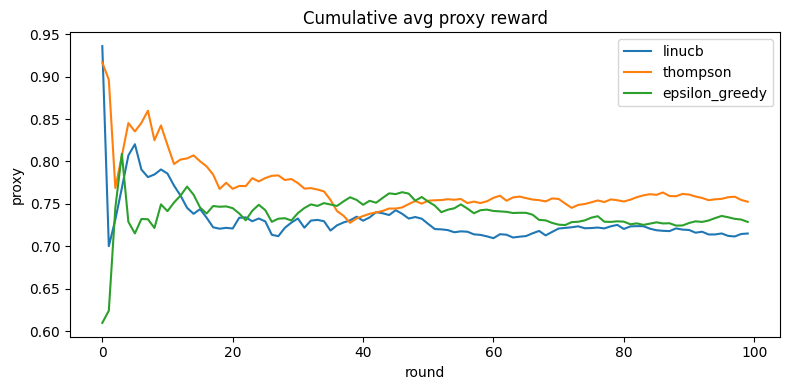

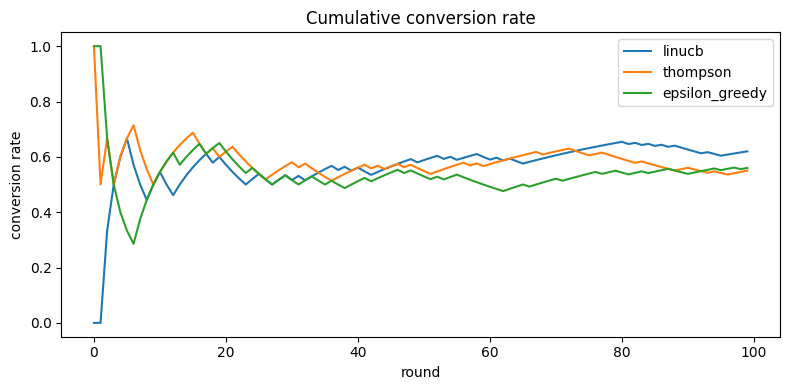

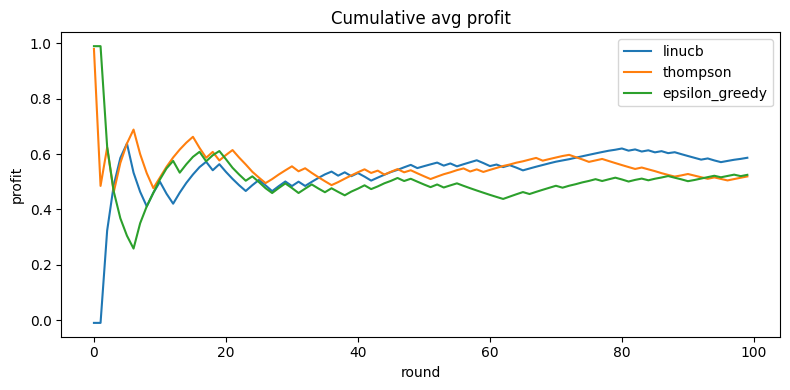

<Figure size 640x480 with 0 Axes>

In [ ]:
%matplotlib inline
%run run.py --rounds 500 --log-rounds 200 --eval-rounds 100

## Implementation Notes (README-style)

### Goals
- Compare three bandit policies: LinUCB, Thompson Sampling, and epsilon-greedy.
- Use a real LLM judge (OpenAI `gpt-4.1-nano`) for proxy rewards.
- Include delayed conversion feedback + noise, plus a safety gate.
- Estimate offline value with Doubly Robust OPE and compare to actual.

###  Design Choices
- Context: continuous embedding (dim=8) plus categorical persona/category features.
- Delay model: exponential delay (mean=50) to mimic long-tail conversions.
- Proxy noise: Gaussian noise (std=0.2) on the judge score.
- Safety: LLM judge returns `unsafe_score`; unsafe if >= 0.5. Model C has 2% unsafe injection.
- Costs/value: A/B/C costs = 0.01/0.02/0.10, conversion value = 1.0.
- OPE: Doubly Robust using logistic regression for conversion probability.

### Code Layout
- `Day_15/sim.py`: environment, contexts, conversion model, delay, costs, safety.
- `Day_15/agents.py`: LinUCB (imported), Thompson Sampling, epsilon-greedy, block features.
- `Day_15/judge.py`: OpenAI judge call returning `{proxy_score, unsafe_score}`.
- `Day_15/ope.py`: DR estimator + logistic regression reward model.
- `Day_15/run.py`: end-to-end training, OPE, evaluation, plots.

### How the Run Works
1) Log N random interactions for OPE.
2) Train each agent for the remaining rounds using proxy reward.
3) Evaluate each learned policy on fresh rounds (actual conversion + profit).
4) Use DR OPE on the log to estimate conversion/profit and compare to actual.